In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.cm.tab20

In [2]:
data = pd.read_csv("dataset/german_credit_data_withrisk.csv", index_col=0)

In [3]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
num_impute = "mean" # One of ["mean", "zero", "infinity"]
cat_impute = "mode" # One of ["mode", "none"]

In [5]:
job_index2word = {
    0: "unskilled and non-resident", 
    1: "unskilled and resident", 
    2: "skilled", 
    3: "highly skilled"
}
def assign_job_type(col):
    return job_index2word[col]

In [6]:
data.Job = data.Job.apply(assign_job_type)

In [7]:
cat_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
num_cols = ['Age', 'Credit amount', 'Duration']

In [8]:
def impute_with_mean(df):
    out = pd.DataFrame(df)
    for col in df.columns:
        if col in num_cols:
            out.loc[out[col].isna(), col] = df[col].mean()
    return out
def impute_with_zero(df):
    out = pd.DataFrame(df)
    for col in df.columns:
        if col in num_cols:
            out.loc[out[col].isna(), col] = 0.0
    return out


def impute_with_infinity(df):
    out = pd.DataFrame(df)
    for col in df.columns:
        if col in num_cols:
            out.loc[out[col].isna(), col] = float("inf")
    return out
def impute_with_mode(df):
    out = pd.DataFrame(df)
    for col in df.columns:
        if col in cat_cols:
            out.loc[out[col].isna(), col] = df[col].mode().iat[0]
    return out
def impute_with_none(df):
    out = pd.DataFrame(df)
    for col in df.columns:
        if col in cat_cols:
            out.loc[out[col].isna(), col] = "None"
    return out

In [9]:
def get_impute_function(name):
    assert name in ["mean", "zero", "infinity", "mode", "none"]
    if name == "mean":
        return impute_with_mean
    elif name == "zero":
        return impute_with_zero
    elif name == "infinity":
        return impute_with_infinity
    elif name == "mode":
        return impute_with_mode
    else:
        return impute_with_none

In [10]:
def impute_missing_values(df, num_impute, cat_impute):
    num_impute_function = get_impute_function(num_impute)
    cat_impute_function = get_impute_function(cat_impute)
    new_df = num_impute_function(df)
    new_df = cat_impute_function(df)
    return new_df

In [11]:
data.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [12]:
data = impute_missing_values(data, num_impute, cat_impute)

In [13]:
data.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [14]:
(data.Risk == "good").sum()

700

In [15]:
(data.Risk == "bad").sum()

300

In [16]:
def cat2onehot(df):
    output = df.copy()
    for col in cat_cols:
        dummies = pd.get_dummies(df[col], prefix="", prefix_sep = col+"_")
        output = pd.concat([dummies, output], axis=1)
  
        output.drop(col, axis=1, inplace=True)
      
    return output

In [17]:
data = cat2onehot(data)

In [18]:
data.columns

Index(['Purpose_business', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others', 'Checking account_little',
       'Checking account_moderate', 'Checking account_rich',
       'Saving accounts_little', 'Saving accounts_moderate',
       'Saving accounts_quite rich', 'Saving accounts_rich', 'Housing_free',
       'Housing_own', 'Housing_rent', 'Job_highly skilled', 'Job_skilled',
       'Job_unskilled and non-resident', 'Job_unskilled and resident',
       'Sex_female', 'Sex_male', 'Age', 'Credit amount', 'Duration', 'Risk'],
      dtype='object')

In [19]:
def normalize_numerical(df):
    output = df.copy()
    norm_params = {}
    for col in num_cols:
        mean = df[col].mean()
        std = df[col].std()
        
        output[col] = (df[col] - mean)/std
        norm_params[col] = {"mean":mean, "std":std}
    return output, norm_params

In [20]:
data, norm_params = normalize_numerical(data)

In [21]:
X = data[data.columns[:-1]].values
y = data.Risk.values

In [22]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_

In [25]:
len(importances)

27

In [26]:
df = pd.DataFrame(dict(features = data.columns[:-1], importance = importances))

In [27]:
df.head()

,features,importance
0,Purpose_business,0.018531
1,Purpose_car,0.028243
2,Purpose_domestic appliances,0.005336
3,Purpose_education,0.017681
4,Purpose_furniture/equipment,0.020799


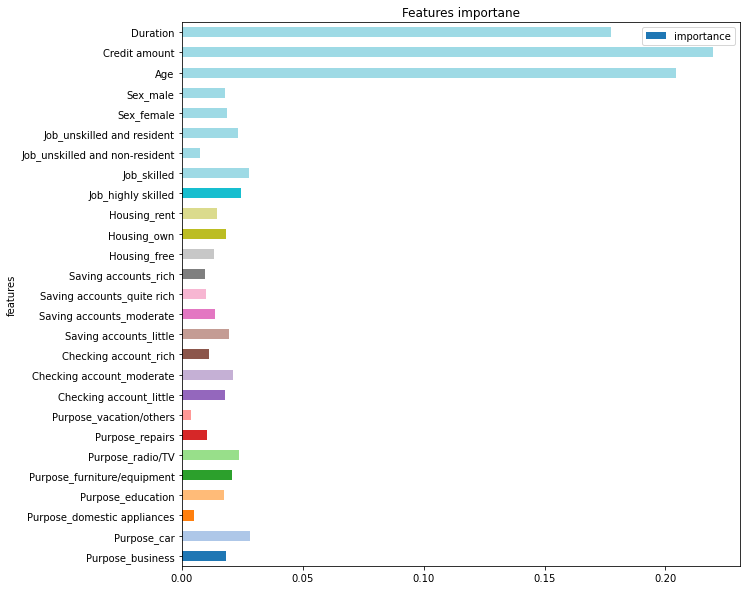

In [53]:
df.plot.barh(x = "features", y = "importance", color = cmap(np.arange(len(df))), figsize=(10, 10), title="Features importane")
plt.show()

In [55]:
from collections import defaultdict

In [67]:
original_columns_importance = defaultdict(float)

In [68]:
for i in range(len(importances)):
    col_name = df.iloc[i, 0]
    if len(col_name.split("_"))  > 1:
        col_name, _ = col_name.split("_")
    original_columns_importance[col_name]+=importances[i]

In [69]:
original_columns_importance

defaultdict(float,
            {'Purpose': 0.12836955479902412,
             'Checking account': 0.05087603439710486,
             'Saving accounts': 0.05361555928526341,
             'Housing': 0.045888671434444125,
             'Job': 0.08314992942225186,
             'Sex': 0.03662737727031451,
             'Age': 0.20415493841845928,
             'Credit amount': 0.21963464283434286,
             'Duration': 0.17768329213879494})

In [72]:
new_df = pd.DataFrame(original_columns_importance.items())

In [82]:
new_df.head(10).sort_values(by=1, ascending=False)

,0,1
7,Credit amount,0.219635
6,Age,0.204155
8,Duration,0.177683
0,Purpose,0.128370
4,Job,0.083150
2,Saving accounts,0.053616
1,Checking account,0.050876
3,Housing,0.045889
5,Sex,0.036627


In [83]:
new_df.columns  = ["feature", "importance"]

<AxesSubplot:ylabel='feature'>

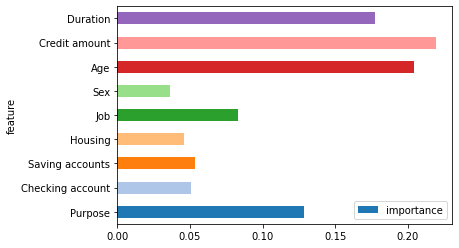

In [86]:
new_df.plot.barh(x = "feature", y="importance", color=cmap(np.arange(len(new_df))))

In [87]:
df.importance.sum()

1.0